### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2024 Semester 2

## Assignment 1

**Student Name:**    Jule Valendo Halim

**Student ID:**     1425567

This iPython notebook is a template which you should use for your Assignment 1 submission. This file should be submitted at the **Assignment 1: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a written report explaining your results at the **Assignment 1: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

In [321]:
# Additional code for Question 2

import numpy as np
import cv2

# Real-world heights for sample objects, in meters (m)
img_dog = 'dog.png'
h_dog = 0.4
img_statue = 'statue.png'
h_statue = 1.8
img_elephant = 'elephant.png'
h_elephant = 3.5

# Read a transparent PNG image
transparent_obj = cv2.imread('dog.png', cv2.IMREAD_UNCHANGED)
obj = transparent_obj[:,:,:3]
alpha = transparent_obj[:,:,3]

# Paste object onto background with transparency
bg = np.ones_like(obj, dtype=np.uint8) * 255
alpha = np.tile(alpha[:,:,np.newaxis], (1,1,3)).astype(np.float32) / 255.0
pasted_object = (obj.astype(np.float32) * alpha) + (bg.astype(np.float32) * (1-alpha))
pasted_object = pasted_object.astype(np.uint8)

### 1. Image filtering

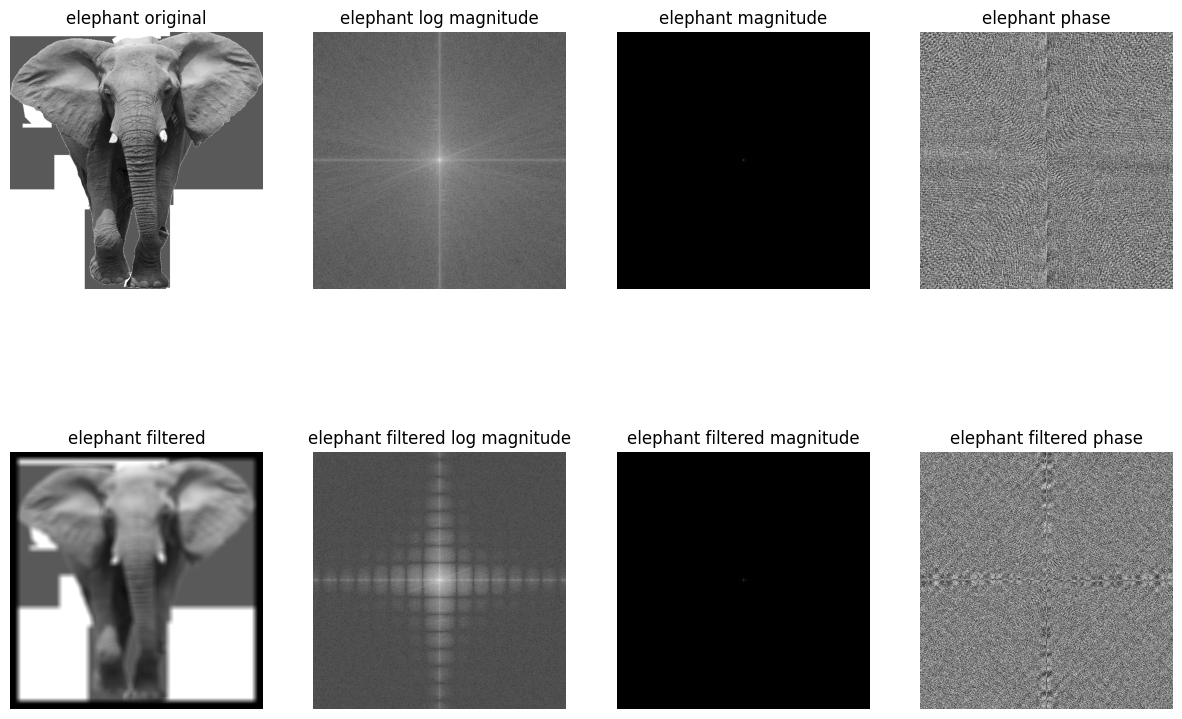

In [322]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
import os

def plot_fourier_transforms(data, filtered_data, title):
    # fourier transform of the original image
    f = fft2(data)
    f = fftshift(f)
    
    # fourier transform of the filtered image
    b = fft2(filtered_data)
    b = fftshift(b)
    
    # calculate phase and magnitude for the original image
    phase = np.angle(f)
    magnitude = np.abs(f)
    log_magnitude = np.log(np.abs(f) + 0.001)
    
    # calculate phase and magnitude for the filtered image
    phase_b = np.angle(b)
    magnitude_b = np.abs(b)
    log_magnitude_b = np.log(np.abs(b) + 0.001)
    
    # begin plotting
    plt.figure(figsize=(15, 10))
    
    # original image
    plt.subplot(2, 4, 1)
    plt.imshow(data, cmap='gray')
    plt.title(f'{title} original')
    plt.axis('off')
    
    # log magnitude of the original image
    plt.subplot(2, 4, 2)
    plt.imshow(log_magnitude, cmap='gray')
    plt.title(f'{title} log magnitude')
    plt.axis('off')
    
    # magnitude of the original image
    plt.subplot(2, 4, 3)
    plt.imshow(magnitude, cmap='gray')
    plt.title(f'{title} magnitude')
    plt.axis('off')
    
    # phase of the original image
    plt.subplot(2, 4, 4)
    plt.imshow(phase, cmap='gray')
    plt.title(f'{title} phase')
    plt.axis('off')
    
    # filtered image
    plt.subplot(2, 4, 5)
    plt.imshow(filtered_data, cmap='gray')
    plt.title(f'{title} filtered')
    plt.axis('off')
    
    # log magnitude of the filtered image
    plt.subplot(2, 4, 6)
    plt.imshow(log_magnitude_b, cmap='gray')
    plt.title(f'{title} filtered log magnitude')
    plt.axis('off')
    
    # magnitude of the filtered image
    plt.subplot(2, 4, 7)
    plt.imshow(magnitude_b, cmap='gray')
    plt.title(f'{title} filtered magnitude')
    plt.axis('off')
    
    # phase of the filtered image
    plt.subplot(2, 4, 8)
    plt.imshow(phase_b, cmap='gray')
    plt.title(f'{title} filtered phase')
    plt.axis('off')
    
    plt.show()

# load image
rootpath = './'
img = cv2.imread(os.path.join(rootpath,img_elephant), cv2.IMREAD_GRAYSCALE)

# box filter and pad size
filter_size = 15
pad_size = 20

# create a box filter
box_filter = np.ones((filter_size, filter_size)) / (filter_size ** 2)

# pad the image
img_padded = cv2.copyMakeBorder(img, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_CONSTANT, value=0)
img_box_filtered = cv2.filter2D(img_padded, -1, box_filter)

plot_fourier_transforms(img, img_box_filtered, "elephant")


### 2. AR object rendering

In [323]:
import cv2
import os
import numpy as np

def insert_object(object_path, object_height, object_x, object_y):
    # dimensions
    focal_length = 15  # mm
    sensor_width = 36  # mm
    sensor_height = 24  # mm
    camera_height = 1.6  # meters

    # Load background image
    rootpath = './'
    background = cv2.imread(os.path.join(rootpath, "background.jpg"))
    background_height, background_width = background.shape[:2]

    # load image
    object_img = cv2.imread(os.path.join(rootpath, object_path), cv2.IMREAD_UNCHANGED)
    obj = object_img[:,:,:3]
    alpha_normalized = object_img[:,:,3]

    # focal length in pixels
    focal_length_pixels = (focal_length / sensor_width) * background_width

    # distance to object based on given object y
    ground_plane_y = background_height 
    if object_y > ground_plane_y:
        object_y = ground_plane_y

    # calculate the distance to the object
    distance_to_object = camera_height * focal_length_pixels / (object_y)  

    # calculate the object height in pixels
    object_height_pixels = int((focal_length_pixels * object_height) / distance_to_object)

    # Ensure the object fits in the image
    if object_height_pixels > background_height:
        object_height_pixels = background_height

    # maintain the aspect ratio
    aspect_ratio = obj.shape[1] / obj.shape[0]
    object_width_pixels = int(object_height_pixels * aspect_ratio)

    # resize image and alpha
    resized_obj = cv2.resize(obj, (object_width_pixels, object_height_pixels))
    resized_alpha = cv2.resize(alpha_normalized, (object_width_pixels, object_height_pixels))

    # calculate start and end positions
    x_start = int(object_x - (object_width_pixels // 2))
    y_start = int(object_y - object_height_pixels)
    x_end = min(background_width, x_start + object_width_pixels)
    y_end = min(background_height, y_start + object_height_pixels)

    # fit object onto background image
    if x_start < 0:
        resized_obj = resized_obj[:, -x_start:]
        resized_alpha = resized_alpha[:, -x_start:]
        x_start = 0

    if y_start < 0:
        resized_obj = resized_obj[-y_start:, :]
        resized_alpha = resized_alpha[-y_start:, :]
        y_start = 0

    if x_end > background_width:
        resized_obj = resized_obj[:, :background_width-x_start]
        resized_alpha = resized_alpha[:, :background_width-x_start]
        x_end = background_width

    if y_end > background_height:
        resized_obj = resized_obj[:background_height-y_start, :]
        resized_alpha = resized_alpha[:background_height-y_start, :]
        y_end = background_height

    # add the image with transparency
    alpha = np.tile(resized_alpha[:,:,np.newaxis], (1,1,3)).astype(np.float32) / 255.0
    background[y_start:y_end, x_start:x_end] = (
        resized_obj.astype(np.float32) * alpha +
        background[y_start:y_end, x_start:x_end].astype(np.float32) * (1 - alpha)
    ).astype(np.uint8)

    return background

# elephant
output_image = insert_object(img_elephant, h_elephant, 2000, 2000) 
cv2.imwrite('elephant(2000x2000).jpg', output_image)

output_image = insert_object(img_elephant, h_elephant, 1500, 1400) 
cv2.imwrite('elephant(1500x1400).jpg', output_image)

# dog
output_image = insert_object(img_dog, h_dog, 2000, 2000) 
cv2.imwrite('dog(2000x2000).jpg', output_image)

output_image = insert_object(img_dog, h_dog, 1500, 1000) 
cv2.imwrite('dog(1500x1000).jpg', output_image)


True